# 网络中的网络（NiN）
:label:`sec_nin`

LeNet、AlexNet和VGG都有一个共同的设计模式：通过一系列的卷积层与汇聚层来提取空间结构特征；然后通过全连接层对特征的表征进行处理。
AlexNet和VGG对LeNet的改进主要在于如何扩大和加深这两个模块。
或者，可以想象在这个过程的早期使用全连接层。然而，如果使用了全连接层，可能会完全放弃表征的空间结构。
*网络中的网络*（*NiN*）提供了一个非常简单的解决方案：在每个像素的通道上分别使用多层感知机 :cite:`Lin.Chen.Yan.2013`

## (**NiN块**)

回想一下，卷积层的输入和输出由四维张量组成，张量的每个轴分别对应样本、通道、高度和宽度。
另外，全连接层的输入和输出通常是分别对应于样本和特征的二维张量。
NiN的想法是在每个像素位置（针对每个高度和宽度）应用一个全连接层。
如果我们将权重连接到每个空间位置，我们可以将其视为$1\times 1$卷积层（如 :numref:`sec_channels`中所述），或作为在每个像素位置上独立作用的全连接层。
从另一个角度看，即将空间维度中的每个像素视为单个样本，将通道维度视为不同特征（feature）。

 :numref:`fig_nin`说明了VGG和NiN及它们的块之间主要架构差异。
NiN块以一个普通卷积层开始，后面是两个$1 \times 1$的卷积层。这两个$1 \times 1$卷积层充当带有ReLU激活函数的逐像素全连接层。
第一层的卷积窗口形状通常由用户设置。
随后的卷积窗口形状固定为$1 \times 1$。

![对比 VGG 和 NiN 及它们的块之间主要架构差异。](../img/nin.svg)
:width:`600px`
:label:`fig_nin`


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

## [**NiN模型**]

最初的NiN网络是在AlexNet后不久提出的，显然从中得到了一些启示。
NiN使用窗口形状为$11\times 11$、$5\times 5$和$3\times 3$的卷积层，输出通道数量与AlexNet中的相同。
每个NiN块后有一个最大汇聚层，汇聚窗口形状为$3\times 3$，步幅为2。

NiN和AlexNet之间的一个显著区别是NiN完全取消了全连接层。
相反，NiN使用一个NiN块，其输出通道数等于标签类别的数量。最后放一个*全局平均汇聚层*（global average pooling layer），生成一个对数几率	（logits）。NiN设计的一个优点是，它显著减少了模型所需参数的数量。然而，在实践中，这种设计有时会增加训练模型的时间。


In [21]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

我们创建一个数据样本来[**查看每个块的输出形状**]。


In [22]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## [**训练模型**]

和以前一样，我们使用Fashion-MNIST来训练模型。训练NiN与训练AlexNet、VGG时相似。


In [3]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)


很难收敛，需要训练很多epoch，10次是不够的

loss 1.810, train acc 0.275, test acc 0.294
2263.1 examples/sec on cuda:0


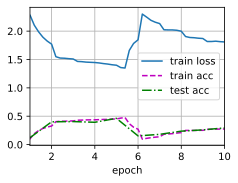

In [24]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.167, train acc 0.939, test acc 0.916
2276.3 examples/sec on cuda:0


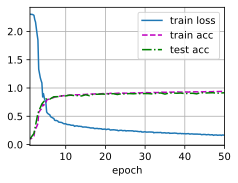

In [28]:
d2l.train_ch6(net, train_iter, test_iter, 50, 0.05, d2l.try_gpu())

## 小结

* NiN使用由一个卷积层和多个$1\times 1$卷积层组成的块。该块可以在卷积神经网络中使用，以允许更多的每像素非线性。
* NiN去除了容易造成过拟合的全连接层，将它们替换为全局平均汇聚层（即在所有位置上进行求和）。该汇聚层通道数量为所需的输出数量（例如，Fashion-MNIST的输出为10）。
* 移除全连接层可减少过拟合，同时显著减少NiN的参数。
* NiN的设计影响了许多后续卷积神经网络的设计。



## 练习

1. 调整NiN的超参数，以提高分类准确性。
1. 为什么NiN块中有两个$1\times 1$卷积层？删除其中一个，然后观察和分析实验现象。
1. 计算NiN的资源使用情况。
    1. 参数的数量是多少？
    1. 计算量是多少？
    1. 训练期间需要多少显存？
    1. 预测期间需要多少显存？
1. 一次性直接将$384 \times 5 \times 5$的表示缩减为$10 \times 5 \times 5$的表示，会存在哪些问题？
    


## 练习解答

### 1. 调整NiN的超参数，以提高分类准确性。


In [11]:
net = nn.Sequential(
    nin_block(1, 64, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(64, 128, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(128, 256, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(256, 64, kernel_size=3, strides=1, padding=1),
    nin_block(64, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

loss 0.260, train acc 0.903, test acc 0.898
4029.5 examples/sec on cuda:0


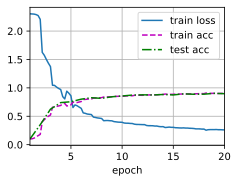

In [12]:
lr, num_epochs = 0.1, 20
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 2. 为什么NiN块中有两个$1\times 1$卷积层？删除其中一个，然后观察和分析实验现象。


In [16]:

def nin_block_1(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        # nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

In [17]:
net_1 = nn.Sequential(
    nin_block_1(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block_1(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block_1(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block_1(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

loss 0.318, train acc 0.882, test acc 0.874
2243.5 examples/sec on cuda:0


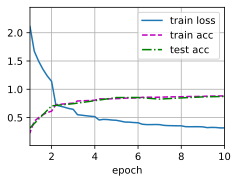

In [18]:
lr, num_epochs = 0.1, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 3. 计算NiN的资源使用情况。
1. 参数的数量是多少？
1. 计算量是多少？
1. 训练期间需要多少显存？
1. 预测期间需要多少显存？


参数数量

In [11]:
!pip install torch-summary

In [ ]:
from torchsummary import summary
summary(net, (1, 224, 224))
"""
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 96, 54, 54]          --
|    └─Conv2d: 2-1                       [-1, 96, 54, 54]          11,712
|    └─ReLU: 2-2                         [-1, 96, 54, 54]          --
|    └─Conv2d: 2-3                       [-1, 96, 54, 54]          9,312
|    └─ReLU: 2-4                         [-1, 96, 54, 54]          --
|    └─Conv2d: 2-5                       [-1, 96, 54, 54]          9,312
|    └─ReLU: 2-6                         [-1, 96, 54, 54]          --
├─MaxPool2d: 1-2                         [-1, 96, 26, 26]          --
├─Sequential: 1-3                        [-1, 256, 26, 26]         --
|    └─Conv2d: 2-7                       [-1, 256, 26, 26]         614,656
|    └─ReLU: 2-8                         [-1, 256, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 256, 26, 26]         65,792
|    └─ReLU: 2-10                        [-1, 256, 26, 26]         --
|    └─Conv2d: 2-11                      [-1, 256, 26, 26]         65,792
|    └─ReLU: 2-12                        [-1, 256, 26, 26]         --
├─MaxPool2d: 1-4                         [-1, 256, 12, 12]         --
├─Sequential: 1-5                        [-1, 384, 12, 12]         --
|    └─Conv2d: 2-13                      [-1, 384, 12, 12]         885,120
|    └─ReLU: 2-14                        [-1, 384, 12, 12]         --
|    └─Conv2d: 2-15                      [-1, 384, 12, 12]         147,840
|    └─ReLU: 2-16                        [-1, 384, 12, 12]         --
|    └─Conv2d: 2-17                      [-1, 384, 12, 12]         147,840
|    └─ReLU: 2-18                        [-1, 384, 12, 12]         --
├─MaxPool2d: 1-6                         [-1, 384, 5, 5]           --
├─Dropout: 1-7                           [-1, 384, 5, 5]           --
├─Sequential: 1-8                        [-1, 10, 5, 5]            --
|    └─Conv2d: 2-19                      [-1, 10, 5, 5]            34,570
|    └─ReLU: 2-20                        [-1, 10, 5, 5]            --
|    └─Conv2d: 2-21                      [-1, 10, 5, 5]            110
|    └─ReLU: 2-22                        [-1, 10, 5, 5]            --
|    └─Conv2d: 2-23                      [-1, 10, 5, 5]            110
|    └─ReLU: 2-24                        [-1, 10, 5, 5]            --
├─AdaptiveAvgPool2d: 1-9                 [-1, 10, 1, 1]            --
├─Flatten: 1-10                          [-1, 10]                  --
==========================================================================================
Total params: 1,992,166
Trainable params: 1,992,166
Non-trainable params: 0
Total mult-adds (M): 764.29
==========================================================================================
Input size (MB): 0.19
Forward/backward pass size (MB): 11.64
Params size (MB): 7.60
Estimated Total Size (MB): 19.43
==========================================================================================
"""

计算量和参数量

In [13]:
!pip install thop

Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)


In [21]:
from thop import profile, clever_format
# 定义输入数据的维度
input = torch.randn(1, 1, 224, 224)

# 使用thop.profile计算FLOPs
flops, params = profile(net.to("cuda"), (input.to('cuda'), ), verbose=False)

# 使用clever_format格式化输出
flops, params = clever_format([flops, params], "%.3f")  # 格式化为字符串

# 打印结果，注意这里需要将格式化后的字符串转换回数值
print('Total GFLOPS: %s' % (float(flops[:-1])))  # 转换为十亿次浮点运算
print('Total params: %s' % params)

Total GFLOPS: 1.525
Total params: 1.992M


模型占用显存

In [4]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())
#    Defined in :numref:`sec_utils`"""
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
net.to(d2l.try_gpu())
torch.cuda.synchronize()
print("Allocated:", torch.cuda.memory_allocated() / 1024**2, "MB")
print("Cached:", torch.cuda.memory_cached() / 1024**2, "MB")

Allocated: 7.6015625 MB
Cached: 22.0 MB


d:\env\anaconda\envs\d2l-zh\lib\site-packages\torch\cuda\memory.py:440: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [6]:
lr = 0.1

In [7]:
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

训练时占用显存

In [8]:
net.train()
X, y = next(iter(train_iter))
X, y = X.to(d2l.try_gpu()), y.to(d2l.try_gpu())
optimizer.zero_grad()
y_hat = net(X)
l = loss(y_hat, y)
l.backward()
optimizer.step()
torch.cuda.synchronize()
print("Allocated:", torch.cuda.memory_allocated() / 1024**2, "MB")
print("Cached:", torch.cuda.memory_cached() / 1024**2, "MB")

Allocated: 39.70947265625 MB
Cached: 1212.0 MB


In [9]:
net.eval()
X, y = next(iter(test_iter))
X, y = X.to(d2l.try_gpu()), y.to(d2l.try_gpu())
y_hat = net(X)
torch.cuda.synchronize()
print("Allocated:", torch.cuda.memory_allocated() / 1024**2, "MB")
print("Cached:", torch.cuda.memory_cached() / 1024**2, "MB")

Allocated: 947.76318359375 MB
Cached: 1524.0 MB


### 4. 一次性直接将$384 \times 5 \times 5$的表示缩减为$10 \times 5 \times 5$的表示，会存在哪些问题？

1. **维度压缩问题**：从384个特征通道直接压缩到10个特征通道，意味着大量的特征信息可能会丢失。这可能导致模型无法捕捉到足够的细节来区分不同的类别。

2. **过拟合风险**：如果特征维度压缩得过于剧烈，模型可能会变得过于依赖于训练数据中的特定特征，从而在新数据上表现不佳。

3. **梯度消失/爆炸问题**：在深度网络中，如果特征维度变化过大，可能会导致梯度在反向传播过程中消失或爆炸，影响模型的训练效果。

4. **计算效率问题**：虽然减少特征维度可以减少计算量，但这种剧烈的压缩可能会使得网络的某些部分计算效率降低，因为网络可能需要在后续层中重新学习丢失的特征信息。

5. **特征表示能力下降**：每个类别可能需要不同的特征表示来区分。直接将所有特征压缩到10个通道可能无法提供足够的表示能力来区分不同的类别。

6. **空间信息丢失**：在 \(5 \times 5\) 的特征图中，空间信息被保留。但如果特征表示能力不足，即使空间信息得以保留，模型也可能无法有效利用这些信息进行分类。

在实际应用中，通常会通过逐步减少特征通道的数量，并使用适当的激活函数和正则化技术来平衡特征表示能力和模型复杂度。此外，使用全局平均池化层（Global Average Pooling）而不是全连接层来减少特征维度，可以保持空间信息并减少参数数量。


[Discussions](https://discuss.d2l.ai/t/1869)
